# Prerequisites

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter('ignore')

from package.database import *

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


# [Data Set](http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions) Description

The experiments were carried out with a group of 30 volunteers within an age bracket of 19-48 years. 
They performed a protocol of activities composed of six basic activities: three static postures (standing, sitting, lying) and three dynamic activities (walking, walking downstairs and walking upstairs). 
The experiment also included postural transitions that occurred between the static postures. These are: stand-to-sit, sit-to-stand, sit-to-lie, lie-to-sit, stand-to-lie, and lie-to-stand.

All the participants were wearing a smartphone (Samsung Galaxy S II) on the waist during the experiment execution. 
We captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz using the embedded accelerometer and gyroscope of the device. 
The experiments were video-recorded to label the data manually. The obtained dataset was randomly partitioned into two sets, where 70 percents of the volunteers was selected for generating the training data and 30 percents the test data.

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). 
The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. 
The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used.
From each window, a vector of 561 features was obtained by calculating variables from the time and frequency domain.

In [3]:
with open('./HAPT/activity_labels.txt', 'r') as raw : res = raw.readlines()
activities = []
for ele in res : activities.append(ele.split(' ')[1])

### First observation on Method

Since I use both the features and the raw signals, I tried to link both thanks to the explanations given in the introduction. Since the explanations are kinda clear, a simple check-out is enough to verify whether the features were extracted this way, to make sure both the raw signals and the features match together. We are then good to go ! Secondly, I made sure the labels obtained thanks to the splitting of signals and the reading of the features did match, which was the case.

We will also notice that some of the features labels are redundant, and will provok disturbances into the models. Among them, there is :

In [4]:
with open('./HAPT/features.txt') as raw : lab = raw.readlines()
for ind in range(len(lab)) : lab[ind] = lab[ind].replace('\n','').replace(' ','')
ele = remove_doublon([lbl for lbl in lab if len(np.where(np.asarray(lab) == lbl)[0]) > 1])
print(', '.join(ele))

tBodyAcc-ropy-1, tGravityAcc-ropy-1, tBodyAccJerk-ropy-1, tBodyGyro-ropy-1, tBodyGyroJerk-ropy-1, fBodyAcc-ropy-1, fBodyAcc-Skewness-1, fBodyAcc-Kurtosis-1, fBodyAccJerk-ropy-1, fBodyAccJerk-Skewness-1, fBodyAccJerk-Kurtosis-1, fBodyGyro-ropy-1, fBodyGyro-Skewness-1, fBodyGyro-Kurtosis-1


Concerning the raw signal and their corresponding features, we may observe :

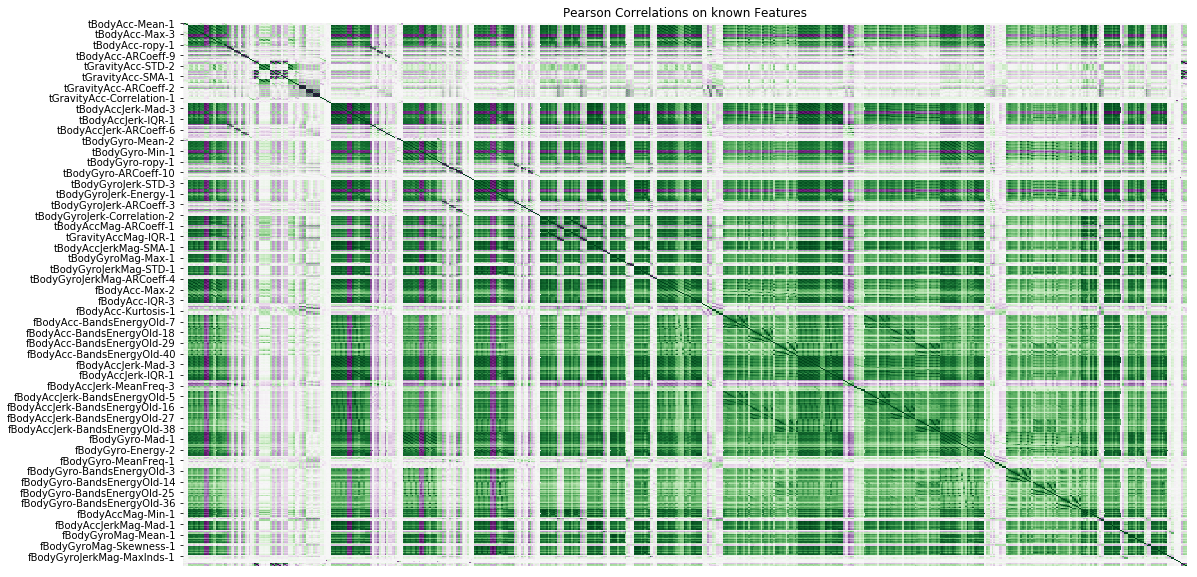

In [8]:
with h5py.File('./dataset/HAPT_ini.h5', 'r') as dtb:
    fea = np.vstack((dtb['fea_t'].value, dtb['fea_v'].value))
    fea = pd.DataFrame(fea, columns=lab)
    
plt.figure(figsize=(18,10))
sns.heatmap(fea.corr(), cmap='PRGn', cbar=False, xticklabels=False)
_ = plt.title('Pearson Correlations on known Features')

As seen above, there are plenty of features strongly correlated together. The information brought thanks to those is clearly redundant, and selection has to be applied, as to enhance the rapidity of the training but also reduce a possible overfitting. Generalisation is still and ever the main aim of such exercice.

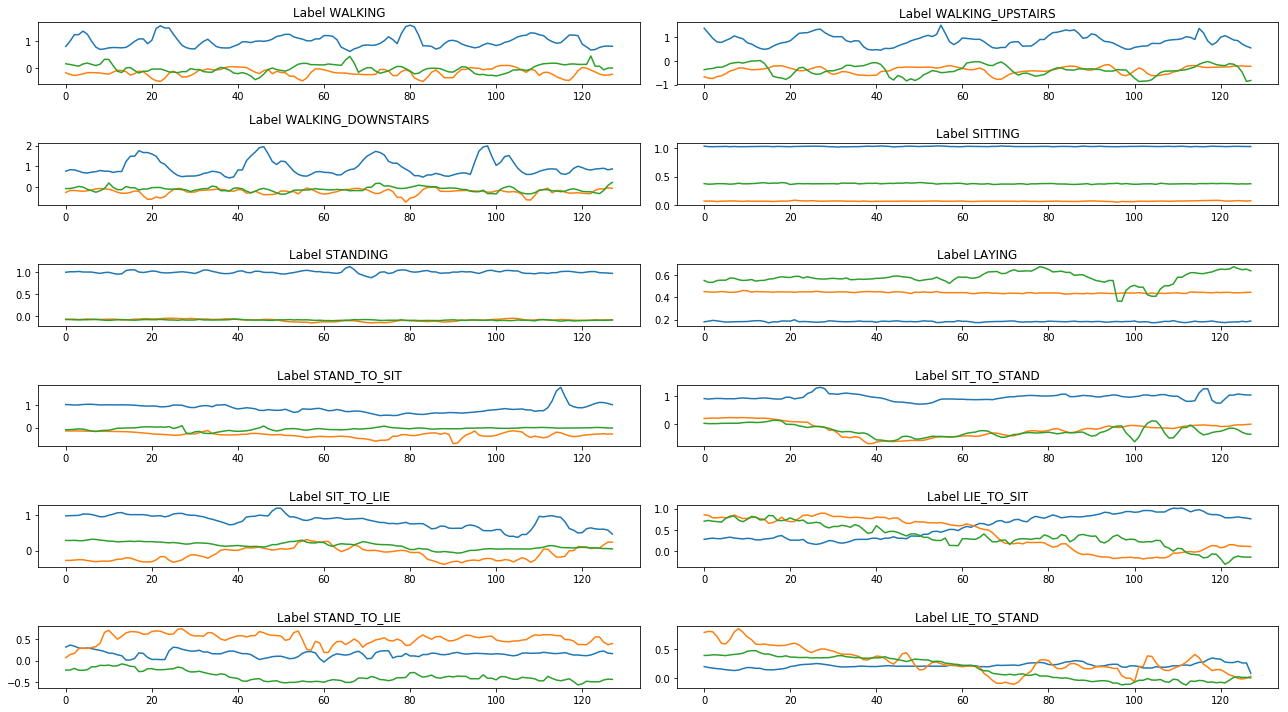

In [13]:
with h5py.File('./dataset/HAPT_ini.h5', 'r') as dtb:
    lab = dtb['label_t'].value
    acc_x = dtb['acc_x_t'].value
    acc_y = dtb['acc_y_t'].value
    acc_z = dtb['acc_z_t'].value

plt.figure(figsize=(18,10))
n_l = len(np.unique(lab))
for ind, ele in enumerate(np.unique(lab)) :
    plt.subplot((n_l + n_l%2)/2, 2, ind+1)
    plt.title('Label {}'.format(activities[ele]))
    plt.plot(acc_x[np.random.choice(np.where(lab == ele)[0])], label='Acc_X')
    plt.plot(acc_y[np.random.choice(np.where(lab == ele)[0])], label='Acc_Y')
    plt.plot(acc_z[np.random.choice(np.where(lab == ele)[0])], label='Acc_Z')
plt.tight_layout()
plt.show()

# Models Without Transitions

This first part consists in the development of my models, on the UCI dataset, which is smaller than the HAPT. The majority classes are the only one given in it, thus making the whole learning process easier. The scores are expected to be a lot higher than for the HAPT dataset.

# Models With Transitions